# Recurrent Neural Network in TensorFlow 2.0
## Univariate, *many-to-many* forecast

Author: **Ivan Bongiorni**, Data Scientist.
[LinkedIn profile](https://www.linkedin.com/in/ivan-bongiorni-b8a583164/).

**Recurrent Neural Networks** are the time series version of Artificial Neural Networks. I will skip the theory behing the recurrent cells available in the Deep Learning literature (basic RNN cells, LSTMs, GRUs) and will show how to implement a basic model in **TensorFlow 2.0** with **Eager execution**. Since LSTM cells are by far the most common, and arguably the most performing RNN cells, I will employ those.

This time, I will show a ***univariate, many-to-many*** RNN implementation. In other words, I will train an RNN forecaster that takes a sequence of data as input, and returns a prediction of a series of following variables state. As in the [previous RNN Notebook](https://github.com/IvanBongiorni/TensorFlow2.0_Tutorial/blob/master/TensorFlow2.0__04.01_RNN_many2one.ipynb) I will show **how to prepare RNN input**, which is not at all clear for a Deep Learning rookie.

*********


***SPOILER: YOU WON'T GET RICH AFTER READING THIS***


*********

Summary:

0. Import data
0. Dataprep for RNNs
0. RNN architecture
0. Prediction
0. Conclusions (i.e. why you didn't become rich)

In [1]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle

import tensorflow as tf
print(tf.__version__)

from matplotlib import pyplot as plt

2.0.0-beta1


# 0. Import data

I can read the data table directly from [coinmarketcap](https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20130428&end=20190626). It reports daily prices, together with volume and market capitalization in US dollars.

Pandas has a `.read_html()` function to take data directly from websites. The link returns two dataframes; daily BTC price data are in the first, therefore I'll keep only that.

In [2]:
df, _ = pd.read_html('https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20130428&end=20190626')

print(df.shape)

(2251, 7)


In [3]:
# I rename col names
df.columns = ['date', 'open', 'high', 'low', 'close', 'volume', 'marketcap']

# Sort df from older to newer
df.sort_index(ascending = False, inplace = True)
df.reset_index(inplace = True)

df.head(10)

,index,date,open,high,low,close,volume,marketcap
0,2250,"Apr 28, 2013",135.30,135.98,132.10,134.21,-,1488566728
1,2249,"Apr 29, 2013",134.44,147.49,134.00,144.54,-,1603768865
2,2248,"Apr 30, 2013",144.00,146.93,134.05,139.00,-,1542813125
3,2247,"May 01, 2013",139.00,139.89,107.72,116.99,-,1298954594
4,2246,"May 02, 2013",116.38,125.60,92.28,105.21,-,1168517495
5,2245,"May 03, 2013",106.25,108.13,79.10,97.75,-,1085995169
6,2244,"May 04, 2013",98.10,115.00,92.50,112.50,-,1250316563
7,2243,"May 05, 2013",112.90,118.80,107.14,115.91,-,1288693176
8,2242,"May 06, 2013",115.98,124.66,106.64,112.30,-,1249023060
9,2241,"May 07, 2013",112.25,113.44,97.70,111.50,-,1240593600


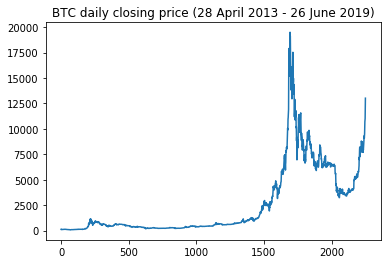

In [4]:
# take BTC daily closing price
price = df.close.values

plt.plot(price)
plt.title('BTC daily closing price (28 April 2013 - 26 June 2019)')
plt.show()

# 1. Dataprep for RNNs

The first thing to do is to scale your time series in the `[0, 1]` interval. Canonical LSTM cells contain **Sigmoid** and **Tanh** gates that do their best when data are in that range.

## Train-Test split
The current analysis is univariate, this means that we are trying to predict future values of a given series exclusively on the basis of its previous states. Because of this, a train-test split must be temporal, i.e. all the observations before a given point in time will be used to train the model, and all the observations after that will be used to test its performance.

In [5]:
test_size = 300

Train = price[:-test_size]
Test = price[-test_size:]

print(len(Train))
print(len(Test))

1951
300


In [6]:
# save max() and min() to revert scaling later
max_price = np.max(Train)
min_price = np.min(Train)

# Min-max scaling:
Train = (Train - min_price) / (max_price - min_price)
Test = (Test - min_price) / (max_price - min_price)

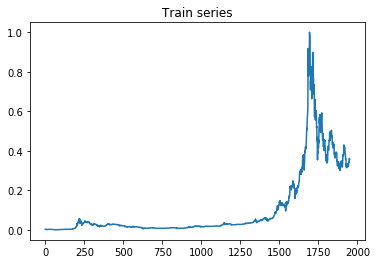

In [7]:
plt.plot(Train)
plt.title('Train series')
plt.show()

## Choosing the input size
A very important hyperparameter is the size of the time window that you are going to feed into the Network at each iteration. Dataprep for RNNs requires series data to be preprocessed in sliding sequences. Given the series:

```
A, B, C, D, E, F, G, H, I
```

and assuming you want to use the previous 3 states to predict the following 2, you would get:

```
Train:        Test:
A, B, C       D, E
B, C, D       E, F
C, D, E       F, G
D, E, F       G, H
E, F, G       H, I
```

The observations RNNs receive as inputs are series of data. Each series covers a time window of the series. Their length is an hyperparameter of the model that one can choose, and that I determined by an input of 180 days. The output sequence will be 7 days instead, meaning I'll try to predict the next week of BTC price.

In [8]:
input_length = 30
prediction_length = 7

In [9]:
# Dataprep function for RNN data

def RNN_dataprep(series, len_input, len_pred):
    '''
    From time series and two hyperparameters: 
    input length and output length, returns Train 
    and Test numpy arrays for many-to-many RNNs.
    
    Args:
        series: time series data
        len_input: length of input sequences
        len_pred: no. of steps ahead to forecast
    '''
    import numpy as np
    
    # create a matrix of sequences
    S = np.empty((len(series)-(len_input+len_pred)+1, 
                  len_input+len_pred))
    
    # take each row/time window
    for i in range(S.shape[0]):
        S[i,:] = series[i : i+len_input+len_pred]
    
    # first (len_input) cols of S are train
    train = S[: , :len_input]
    
    # last (len_pred) cols of S are test
    test = S[: , -len_pred:]
    
    # set common data type
    train = train.astype(np.float32)
    test = test.astype(np.float32)
    
    # reshape data as required by Keras LSTM
    train = train.reshape((len(train), len_input, 1))
    test = test.reshape((len(test), len_pred))
    
    return train, test


In [10]:
# Get all Train and Test data
X_train, Y_train = RNN_dataprep(Train, input_length, prediction_length)

X_test, Y_test = RNN_dataprep(Test, input_length, prediction_length)

## Understand the shape of input data for RNNs

This is a crucial point. It was not at all clear to understand how to reshape the input data for RNNs, and it's important to spend few words on it.

Let's take a look at the shape of input data for Keras' LSTM layers:

In [11]:
print(X_train.shape)
print(X_test.shape)

(1915, 30, 1)
(264, 30, 1)


Input data must follow this pattern:

`( Number of observations , Window size , Number of input series )`

The *Number of observations* is straightforward. The *Number of input series* is just 1, since this is a univariate exercise. *Window size* is the hyperparameter that I chose above.

In this *many-to-many* exercise, test data have the same shape:

In [12]:
print(Y_train.shape)
print(Y_test.shape)

(1915, 7)
(264, 7)


# 2. RNN architecture

The initial LSTM layer requires a specification of its `input_shape`. To correctly specify this, follow this simple rule: take the `X_train.shape`: `(1847, 90, 1)`, drop the first dimension: `(90, 1)`, there you have the correct `input_shape`. It's as easy as that.

For Deep RNNs, each `LSTM()` that is not the last requires `return_sequences = True`. That is because an LSTM layer that is not outputting to `Dense()` layers must receive a series of data to be processed, so you want other layers to return a sequence of data of a kind similar to your input.

The first `Dense()` layer has the same size of the previous `LSTM`s output sequence (90 nodes). This intermediate layer fires to the output layer, that has a number of nodes equal to the number of forecast steps. Regression tasks require no activation function at the output layer, since *no activation* means *linear activation*.

In [13]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten
from tensorflow.keras.activations import relu


RNN = Sequential([ 
    
    LSTM(30, return_sequences=True, input_shape = (input_length, 1)), 
    
    LSTM(30), 
    
    Dense(30, activation = relu), 
    
    Dense(prediction_length, activation = None)
    
])


RNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 30)            3840      
_________________________________________________________________
lstm_1 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense (Dense)                (None, 30)                930       
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 217       
Total params: 12,307
Trainable params: 12,307
Non-trainable params: 0
_________________________________________________________________


I will show how to train a model in **Eager execution**. This will allow us to better understand what happens inside the Network during training (i.e. the weight update through backpropagation) and it will also leave more freedom in implementation and output.

In [14]:
###  TRAINING

# Choose no. cycles, epochs, batch size
cycles = 1000
batch_size = 100
n_epochs = X_train.shape[0] // batch_size

# MAE worked better than MSE this time
loss = tf.keras.losses.MeanAbsoluteError()

optimizer = tf.optimizers.Adam(learning_rate = 0.0001)

# save training progress
loss_history = []

X_t = np.copy(X_train)
Y_t = np.copy(Y_train)


for cycle in range(cycles+1):
    
    # Shuffle the dataset at each new cycle
    X_train, Y_train = shuffle(X_train, Y_train, 
                               random_state = cycle+111)
    
    for epoch in range(n_epochs):
        
        # Take a mini batch
        start = epoch * batch_size
        X_batch = X_train[start:start+batch_size, :, :]
        Y_batch = Y_train[start:start+batch_size, :]
        
        # Update weights (training)
        with tf.GradientTape() as tape:
            current_loss = loss(RNN(X_batch), Y_batch)
        gradients = tape.gradient(current_loss, RNN.trainable_variables)
        optimizer.apply_gradients(zip(gradients, RNN.trainable_variables))
        
    # save history
    loss_history.append(current_loss.numpy())
    
    # Print progress at the end of each cycle
    if (cycle) % 50 == 0:
        print(str(cycle) 
              + '.\t  Training Loss: ' 
              + str(current_loss.numpy()))
#
print('\nTraining complete.')


0.	  Training Loss: 0.07320599
50.	  Training Loss: 0.008682866
100.	  Training Loss: 0.010723087
150.	  Training Loss: 0.010169845
200.	  Training Loss: 0.007114828
250.	  Training Loss: 0.011989551
300.	  Training Loss: 0.010489941
350.	  Training Loss: 0.011471039
400.	  Training Loss: 0.009154794
450.	  Training Loss: 0.0070670755
500.	  Training Loss: 0.007410841
550.	  Training Loss: 0.01028252
600.	  Training Loss: 0.0077179903
650.	  Training Loss: 0.011688027
700.	  Training Loss: 0.010601235
750.	  Training Loss: 0.008248941
800.	  Training Loss: 0.010091783
850.	  Training Loss: 0.009192164
900.	  Training Loss: 0.0065437043
950.	  Training Loss: 0.008875719
1000.	  Training Loss: 0.006385589

Training complete.


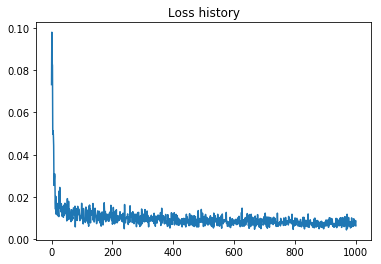

In [15]:
plt.plot(loss_history)
plt.title('Loss history')
plt.show()

# 3. Prediction

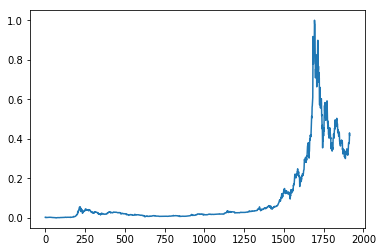

In [16]:
X_tp = X_t.reshape((X_t.shape[0], X_t.shape[1]))

plt.plot(X_tp[:,0])
plt.show()

First, I want to take a look at how good my RNN was able to adapt to the training series:

In [17]:
# Revert min-max scaling
Y_test = Y_test * (max_price - min_price) + min_price

In [18]:
# Generate prediction on test data
P_test = RNN.predict(X_test)

# Revert scaling
P_test = P_test * (max_price - min_price) + min_price

# Reshape the arrays to 2D
Y_test = Y_test.reshape((Y_test.shape[0], Y_test.shape[1]))
P_test = P_test.reshape((P_test.shape[0], P_test.shape[1]))

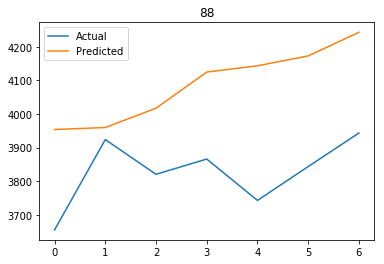

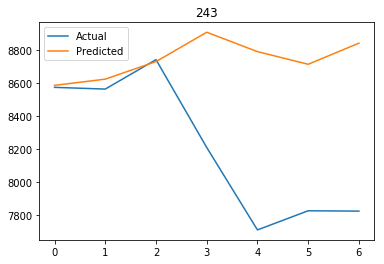

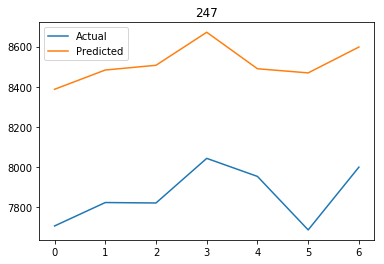

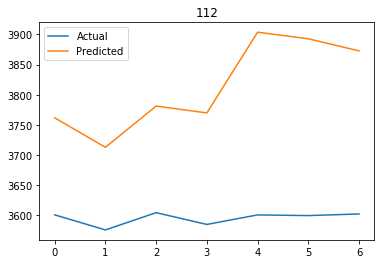

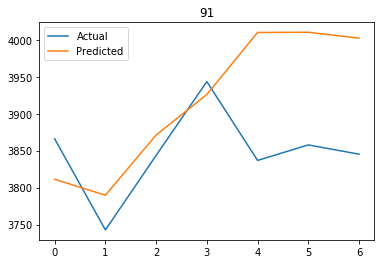

In [19]:
# Let's visualize some 7 day predictions chosen at random:

for i in np.random.randint(low = 0, high = Y_test.shape[0], size = 5):
    plt.plot(Y_test[i,:], label = 'Actual')
    plt.plot(P_test[i,:], label = 'Predicted')
    plt.title(str(i))
    plt.legend()
    plt.show()

Let's check how precise prediction is at different time lags:

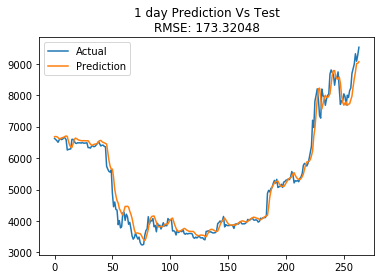

In [20]:
# 1 day prediction

plt.plot(Y_test[:,0], label = 'Actual')
plt.plot(P_test[:,0], label = 'Prediction')
plt.legend()
plt.title('1 day Prediction Vs Test' 
          + '\nRMSE: ' + str(np.mean(np.sqrt((Y_test[:,0] - P_test[:,0])**2))))
plt.show()

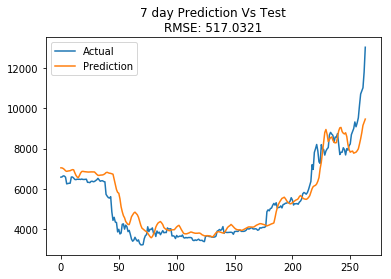

In [21]:
# 7 days prediction

plt.plot(Y_test[:,6], label = 'Actual')
plt.plot(P_test[:,6], label = 'Prediction')
plt.legend()
plt.title('7 day Prediction Vs Test' 
          + '\nRMSE: ' + str(np.mean(np.sqrt((Y_test[:,6] - P_test[:,6])**2))))
plt.show()

The closer we are from Train data, the more accurate it gets. Time series data that are temporally further from Train data are predicted less accurately; this suggests some amount overfitting. Moreover, it seems that abrupt changes are the main challenge for our predictor. You can see in the image above how the 7 days prediction follows sudden changes in the time series with some temporal delay.

Let's check visually the prediction at all the available time lags:

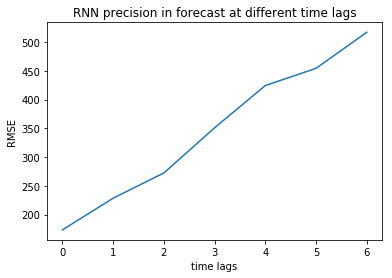

In [22]:
timelag_RMSE = []

for i in range(Y_test.shape[1]):
    timelag_RMSE.append(np.mean(np.sqrt((Y_test[:,i] - P_test[:,i])**2)))

plt.plot(timelag_RMSE)
plt.title('RNN precision in forecast at different time lags')
plt.xlabel('time lags')
plt.ylabel('RMSE')
plt.show()

As the plot show, the RMSE seems to increase quite regularly the more far in the future we try to predict.


# Conclusions (i.e. why you didn't become rich)

Since the first time we heard of Recurrent Neural Networks, we probably all thought about employing these models to predict phenomena such as cryptocurrency or stock market fluctuations. One lesson we can take from this exercise is that time series models are not very effective. As François Chollet explained:

> *Markets have very different statistical characteristics than natural phenomena such as weather patterns. Trying to use machine learning to beat markets, when you only have access to publicly available data, is a difficult endeavor, and you’re likely to waste your time and resources with nothing to show for it.*
>
> *Always remember that when it comes to markets, past performance is not a good predictor of future returns—looking in the rear-view mirror is a bad way to drive. Machine learning, on the other hand, is applicable to datasets where the past is a good predictor of the future.*

François Chollet, *Deep Learning with Python*, Manning, p. 224.